## Guided Project: Created a Kaggle Workflow

In this project, I practice the workflow used to create Kaggle submissions using the Titanic dataset.

In [1]:
import pandas as pd
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# %load functions.py
def process_missing(df):
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, 'Age_categories')
    df = create_dummies(df, 'Fare_categories')
    df = create_dummies(df, 'Cabin_type')
    df = create_dummies(df, 'Title')
    df = create_dummies(df, 'Sex')
    return df

In [4]:
train = process_df(train)
holdout = process_df(holdout)

In [5]:
cols = ['SibSp', 'Parch','Survived']
train[cols].head()

,SibSp,Parch,Survived
0,1,0,0
1,1,0,1
2,0,0,1
3,1,0,1
4,0,0,0


In [6]:
train[cols].dtypes

SibSp       int64
Parch       int64
Survived    int64
dtype: object

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
train['SibSp_cat'] = pd.cut(train['SibSp'], [-1, 0, 1, 3, 5, 5000], labels=['None', 'One','Two to three','Four to five', 'Five or more'])

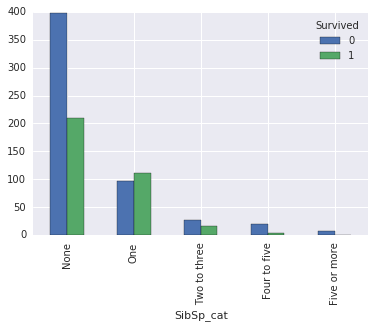

In [8]:
pd.crosstab(index=train['SibSp_cat'], columns=train['Survived']).plot.bar()

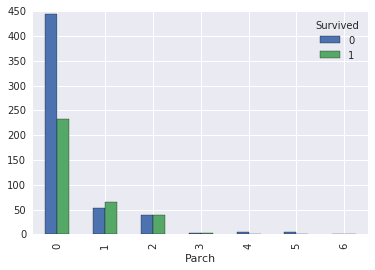

In [9]:
pd.crosstab(index=train['Parch'], columns=train['Survived']).plot.bar()

In [10]:
train['Relatives'] = train['SibSp'] + train['Parch']

In [11]:
pd.crosstab(index=train['Relatives'], columns=train['Survived']).apply(lambda r: r/r.sum(), axis=1)

Survived,0,1
Relatives,,
0,0.696462,0.303538
1,0.447205,0.552795
2,0.421569,0.578431
3,0.275862,0.724138
4,0.800000,0.200000
5,0.863636,0.136364
6,0.666667,0.333333
7,1.000000,0.000000
10,1.000000,0.000000


In [12]:
def process_relatives(df):
    df['Relatives'] = df['SibSp'] + df['Parch']
    df['isalone'] = df['Relatives'].apply(lambda x: 'Yes' if x==0 else 'No')
    return df

In [27]:
train = process_relatives(train)
holdout = process_relatives(holdout)

In [41]:
from sklearn.feature_selection import RFECV 
from sklearn.ensemble import RandomForestClassifier
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    df = df.dropna()
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    rf = RFECV(RandomForestClassifier(), cv=10)
    rf.fit(all_X, all_y)    
    print(all_X.columns[rf.support_])
    return all_X.columns[rf.support_]

In [40]:
features = select_features(train)
print(features)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Cabin_type_C', 'Cabin_type_E', 'Cabin_type_Unknown', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Sex_female', 'Sex_male',
       'Relatives'],
      dtype='object')
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Cabin_type_C', 'Cabin_type_E', 'Cabin_type_Unknown', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Sex_female', 'Sex_male',
       'Relatives'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    models = [
        {
            "name": "LogisticRegression",
            "estimator":LogisticRegression(),
            "hyperparameters":
            {
                "solver":['newton-cg','lbfgs','liblinear'],              
            }
        },
        {
            'name':'KNeighborsClassifier',
            'estimator':KNeighborsClassifier(),
            'hyperparameters':
            {
                'n_neighbors':range(1,20,1),
                'weights':['distance','uniform'],
                'algorithm':['ball_tree', 'kd_tree', 'brute'],
                'p':[1,2]
            }
        },
        {
            'name':'RandomForestClassifier',
            'estimator':RandomForestClassifier(),
            'hyperparameters':
            {
                'n_estimators':[4,6,9],
                'criterion':['entropy','gini'],
                'max_depth':[2,5,10],
                'max_features':['log2','sqrt'],
                'min_samples_leaf':[1,5,8],
                'min_samples_split':[2,3,5]
            }
        }
    ]
    
    for model in models:
        print(model['name'])
        grid = GridSearchCV(model['estimator'],
                            model['hyperparameters'])
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['score'] = grid.best_score_
        model['best_estimator'] = grid.best_estimator_
        print(model['best_params'])
        print(model['score'])
    
    return models

In [43]:
models_selected = select_model(train, features)

LogisticRegression
{'solver': 'lbfgs'}
0.8215488215488216
KNeighborsClassifier
{'algorithm': 'ball_tree', 'weights': 'distance', 'n_neighbors': 16, 'p': 1}
0.7665544332210998
RandomForestClassifier
{'max_depth': 5, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 6, 'max_features': 'log2'}
0.8383838383838383


In [86]:
def save_submission_file(model, columns, filename = "submission.csv"):
    predictions = model.predict(holdout[columns])
    submission = pd.concat([holdout[['PassengerId']], pd.DataFrame(predictions, columns=['Survived'])], axis=1)
    submission = pd.DataFrame(submission)
    submission.to_csv(filename, index=False)
    return submission


In [87]:
save_submission_file(models_selected[2]['best_estimator'], features)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
